# Deep Learning Time Series COVID-19 Cases Prediction

## Project Setup

### Dependencies importing

In [3]:
# Auto reload imported module every time a jupyter cell is executed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
import pandas_profiling
from typing import overload
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop 
from covid_time_series_prediction.ml_logic import preprocessor
from covid_time_series_prediction.dp_logic.sequencing import subsample_sequence, get_X_y, get_X_y_2
from covid_time_series_prediction.dp_logic.RNN_model import model_run
from covid_time_series_prediction.ml_logic.preprocessor import train_test_set

## Data loading

In [10]:
data_dir = '../data/raw_data/'

df_raw_gov_response = pd.read_csv(data_dir + 'government_response_index_avg.csv')
df_raw_health = pd.read_csv(data_dir + 'containment_health_index_avg.csv')
df_raw_economic = pd.read_csv(data_dir + 'economic_support_index.csv')

#### Vaccination
df_raw_vaccination = pd.read_csv(data_dir + 'vaccinations.csv')
df_raw_ages = pd.read_csv(data_dir + 'vaccinations-by-age-group.csv')


#### Data Frame target
df_raw_cases = pd.read_csv(data_dir + 'confirmed_cases.csv')
df_raw_deaths = pd.read_csv(data_dir + 'confirmed_deaths.csv')

#### Data multiple
df_raw_school_closing=pd.read_csv(data_dir + 'c1m_school_closing.csv')
df_raw_workplace_closing=pd.read_csv(data_dir + 'c2m_workplace_closing.csv')
df_raw_cancel_public_event=pd.read_csv(data_dir + 'c3m_cancel_public_events.csv')
df_raw_restriction_on_gathering=pd.read_csv(data_dir + 'c4m_restrictions_on_gatherings.csv')
df_raw_stay_at_home=pd.read_csv(data_dir + 'c6m_stay_at_home_requirements.csv')
df_raw_international_travel=pd.read_csv(data_dir + 'c6m_stay_at_home_requirements.csv')
df_raw_goverment_response=pd.read_csv(data_dir + 'government_response_index_avg.csv')
df_raw_facial_covering=pd.read_csv(data_dir + 'h6m_facial_coverings.csv')
df_raw_vacination_policy=pd.read_csv(data_dir + 'h7_vaccination_policy.csv')


### **Read out CSV** and **Set dataframe**

In [11]:
#### CSV Data out project directory
csv_dir = '../data/out_csv/'
# ! unzip {csv_dir}usa_index
# ! unzip {csv_dir}usa_indicator
# ! rm ECG_data.zip
df_fr_index =  pd.read_csv(csv_dir + 'index_FRA.csv')
df_fr_indicator =  pd.read_csv(csv_dir + 'indicator_FRA.csv')
df_fr_index, df_fr_indicator


(           date  cancel_public_events  school_closing  \
 0    2020-02-15                   0.0             0.0   
 1    2020-02-16                   0.0             0.0   
 2    2020-02-17                   0.0             0.0   
 3    2020-02-18                   0.0             0.0   
 4    2020-02-19                   0.0             0.0   
 ..          ...                   ...             ...   
 934  2022-09-06                   0.0             0.0   
 935  2022-09-07                   0.0             0.0   
 936  2022-09-08                   0.0             0.0   
 937  2022-09-09                   0.0             0.0   
 938  2022-09-10                   0.0             0.0   
 
      restrictions_on_gathering  close_public_transport  \
 0                          0.0                     0.0   
 1                          0.0                     0.0   
 2                          0.0                     0.0   
 3                          0.0                     0.0   
 4     

## DataFrames setting

In [12]:
# Sumedha csv test

df_ts_fra_index =  df_fr_index.copy()
df_ts_fra_indicator =  df_fr_indicator.copy()

df_ts_fra_index.head(), df_ts_fra_indicator.head()

(         date  cancel_public_events  school_closing  \
 0  2020-02-15                   0.0             0.0   
 1  2020-02-16                   0.0             0.0   
 2  2020-02-17                   0.0             0.0   
 3  2020-02-18                   0.0             0.0   
 4  2020-02-19                   0.0             0.0   
 
    restrictions_on_gathering  close_public_transport  \
 0                        0.0                     0.0   
 1                        0.0                     0.0   
 2                        0.0                     0.0   
 3                        0.0                     0.0   
 4                        0.0                     0.0   
 
    stay_at_home_requirements  restrictions_on_internal_movement  \
 0                        0.0                                0.0   
 1                        0.0                                0.0   
 2                        0.0                                0.0   
 3                        0.0                 

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X=df_ts_fra_indicator.drop(columns=['total_deaths','new_deaths','new_cases'])
y=df_ts_fra_indicator['total_deaths']



scaler = MinMaxScaler()
scaler.fit_transform(X)

train = int((len(X)*split_train))
val = int(len(X)*split_val)

X_train = X[:train]
y_train = y[:train]

X_val = X[train:val]
y_val = y[train:val]

X_test = X[val:]
y_test = y[val:]

scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
n = len(X)
X_train = X[0:int(n*0.8)]
X_test=X[int(n*0.8):]
y_train=y[0:int(n*0.8)]
y_test=y[int(n*0.8):]


ValueError: could not convert string to float: '2020-02-15'

## TENSORFLOW & RNN MODEL

### Recurrent Neural Network (sequences data) modeling

### Samples/Sequences, Observations, Features

X.shape = (n_SEQUENCES, n_OBSERVATIONS, n_FEATURES) and y = RNN(X) where $X_{i,j}^{t}$

with $_{i}$ is the sample/sequence, $_{j}$ is the feature measured and  $^{t}$ is the time at which the observation is seen



### Prerequisites:

- **retrieve dataset** from Sumedha & Alberto

    - **clean dataset**: 
        
        - **drop first lines == 0** *(before Covid arrived)*
        
        - **check Nan**: 
- **strategy 1 country by country** sequences split as follow:

- **strategy 2 one sequence per country**:
    - **split X train, set** 
    - **Pad sequences**
    - **create one csv per country**

## Training strategies:
- Get NB dataset (cleaned) from Alberto & Sumedha
- 1/ Indicator in precentage %
- 2/ Indicator as categorical labels
- Run same RNN model in parallel with Kim & Thomas
- Identify best dataset
- Parameters to fit:
    - increase **nb of sequences**
    - train series modulation (ex: [50, 150, 200, 300, 400 nb of days = n_obs]) < take time to compute
    - **learning_rate** in Optimizer(parameters)
    - model layers architecture (**simple** -> complex) (less data -> more data) (print(loss) function check lecture)
        > LSTM
        > Dense
       (> LSTM
        > LSTM
        > Dense)
     >> **try to overfit** the model with the loss (train over val) or (early_stopping)
     >> **(X_val, y_val)**

## RNN model #4 on USA countries

In [26]:
# Alberto train set
n_seq = 200 ## nb of sequences (samples)
n_obs = [70, 65, 60] # maxi = 96 (stay around 70 or more test_split)
n_obs = 70 # maxi = 96 (stay around 70 or more test_split)
n_feat = 20 #  X_train.shape[1] # 20 feature:
n_pred = 10 # nb of days where we can predict new daily deaths
n_pred = 1 ## <<< REMOVE AFTER OK TESTING!
n_seq_val = n_seq // 5 # number of sequences in test set ?
n_seq_test = n_seq // 10 # number of sequences in test set ?
print('n_seq\t\t', n_seq, '\nn_seq_val\t', n_seq_val, '\nn_seq_test\t', n_seq_test, '\nn_obs\t\t', n_obs, '\nn_feat\t\t', n_feat)

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20


### Train Splitting

Split the dataset into training, validation, and test data

In [27]:
# Alberto train set
X_train, y_train, X_val, y_val, X_test, y_test = train_test_set('Vietnam', split_train=0.7, split_val=0.9)
print('X_train.shape\t', X_train.shape, '\t->\ty_train shape\t', y_train.shape, '\nX_val.shape\t', X_val.shape, '\t->\ty_val shape\t', y_val.shape, '\nX_test.shape\t', X_test.shape, '\t->\ty_test shape\t', y_test.shape)

X_train.shape	 (673, 21) 	->	y_train shape	 (673,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)


#### Create sequences (`X`,`y`, `X_len`, `y_len`)

##### Generates an entire dataset of multiple subsamples with shape $(X, y)$

In [28]:
# Test it
(X_sample, y_sample) = subsample_sequence(X_train, y_train, X_len=n_obs, y_len=n_pred) # n_seq = 200, n_obs = 150
X_sample.shape, y_sample.shape

((70, 21), (1,))

In [29]:
X_test, y_test = get_X_y_2(X_test, y_test, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_test)
print('n_seq_test / n_obs / n_feat', n_seq_test, n_obs, n_feat, '\nX_test.shape', X_test.shape, 'y_test.shape', y_test.shape) 

n_seq_test / n_obs / n_feat 20 70 20 
X_test.shape (20, 70, 21) y_test.shape (20, 1)


In [30]:
X_train, y_train = get_X_y_2(X_train, y_train, X_len=n_obs, y_len=n_pred, n_sequences=n_seq)
print('n_seq / n_obs / n_feat', n_seq, n_obs, n_feat, '\nX_train.shape', X_train.shape, 'y_train.shape', y_train.shape) 

n_seq / n_obs / n_feat 200 70 20 
X_train.shape (200, 70, 21) y_train.shape (200, 1)


In [31]:
X_val, y_val = get_X_y_2(X_val, y_val, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_val)
print('n_seq_val / n_obs / n_feat', n_seq_val, n_obs, n_feat, '\nX_val.shape', X_val.shape, 'y_val.shape', y_val.shape) 

n_seq_val / n_obs / n_feat 40 70 20 
X_val.shape (40, 70, 21) y_val.shape (40, 1)


##### How to split sequences?



- randomly or

- manually

##### **train_rnn_model(model, patience=2, epochs=200):**

function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

### Model #4 Training

In [32]:
print('X_train.shape\t', X_train.shape, '\t->\ty_train shape\t', y_train.shape, '\nX_val.shape\t', X_val.shape, '\t->\ty_val shape\t', y_val.shape, '\nX_test.shape\t', X_test.shape, '\t->\ty_test shape\t', y_test.shape)
print('type(X_train)\t', type(X_train), '\t->\ttype(y_train)\t', type(y_train), '\ntype(X_val)\t', type(X_val), '\t->\ttype(y_val)\t', type(y_val), '\ntype(X_test)\t', type(X_test), '\t->\ttype(y_test)\t', type(y_test))


X_train.shape	 (200, 70, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 70, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 70, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>


In [33]:
# Alberto model #4 test 
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_4 = Sequential()
# rnn_model_4.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_4.add(LSTM(units=20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_4.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_4.add(Dense(n_pred, activation = 'linear'))
#ValueError: Input 0 of layer "lstm_1" is incompatible with the layer:
#     >>> expected ndim=3, found ndim=2. Full shape received: (None, 20)#
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_4.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_4.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                3360      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,581
Trainable params: 3,581
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
12/12 [==============================] - 1s 27ms/step - loss: 84883800.0000 - mape: 2869395712.0000 - val_loss: 102555792.0000 - val_mape: 3300164096.0000
Epoch 2/200
12/12 [==============================] - 0s 10ms/step - loss: 84716504.0000 - mape: 5641335296.0000 - val_loss: 102467216.0000 - val_mape: 5655231488.0000
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 82593112.0000 - mape: 7348536320.0000 - val_loss: 99112592.0000 - val_mape: 20893034496.0000
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 82843640.0000 - mape: 29588291584.0000 - val_loss: 93366488.0000 - val_mape: 4866661376.0000
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 79987592.0000 - mape: 53797081088.0000 - val_loss: 100531744.0000 - val_mape: 80921935872.0000
Epoch 6/200
12/12 [==============================] - 0s 11ms/step - loss: 82454688.0000 - mape: 40454709248.0000 - val_loss: 102278224.0000 - val_mape: 40471797760

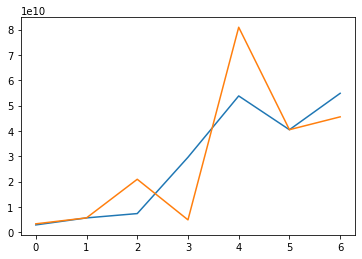

In [34]:
# 3. Training
history = train_rnn_model(model=rnn_model_4, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=200, patience=3)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();

# 4. Evaluating
# The prediction (one per sequence/city)
# y_pred = rnn_model.predict(X_test) 
# print(y_pred.shape)
# Distribution of the predictions
# pd.DataFrame(y_pred).mean().sort_values(ascending=False)

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 [62, 60, 58] 
n_feat		 20
NB OF OBSERVATIONS TO TRAIN: 62
LEARNING RATE: 0.1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 62 20 
X_train.shape (200, 62, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 62 20 
X_val.shape (40, 62, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 62 20 
X_test.shape (20, 62, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 62, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 62, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 62, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (62, 21)
Model: "se

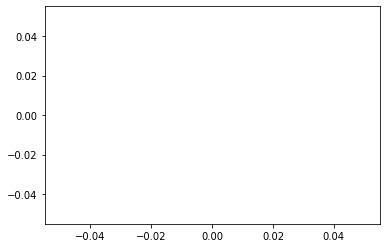

NB OF OBSERVATIONS TO TRAIN: 62
LEARNING RATE: 0.01
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 62 20 
X_train.shape (200, 62, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 62 20 
X_val.shape (40, 62, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 62 20 
X_test.shape (20, 62, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 62, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 62, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 62, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (62, 21)
Model: "sequential_66"
________________________________________________________________

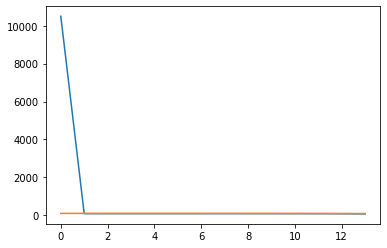

NB OF OBSERVATIONS TO TRAIN: 62
LEARNING RATE: 0.001
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 62 20 
X_train.shape (200, 62, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 62 20 
X_val.shape (40, 62, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 62 20 
X_test.shape (20, 62, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 62, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 62, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 62, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (62, 21)
Model: "sequential_67"
_______________________________________________________________

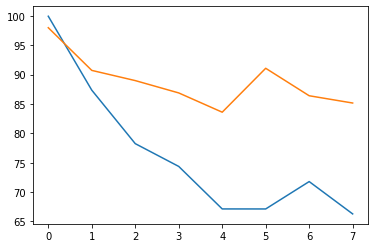

NB OF OBSERVATIONS TO TRAIN: 60
LEARNING RATE: 0.1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 60 20 
X_train.shape (200, 60, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 60 20 
X_val.shape (40, 60, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 60 20 
X_test.shape (20, 60, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 60, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 60, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 60, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (60, 21)
Model: "sequential_68"
_________________________________________________________________

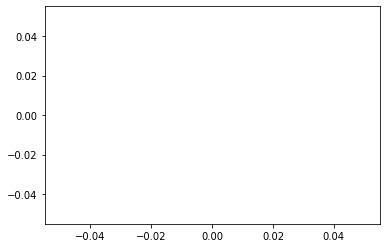

NB OF OBSERVATIONS TO TRAIN: 60
LEARNING RATE: 0.01
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 60 20 
X_train.shape (200, 60, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 60 20 
X_val.shape (40, 60, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 60 20 
X_test.shape (20, 60, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 60, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 60, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 60, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (60, 21)
Model: "sequential_69"
________________________________________________________________

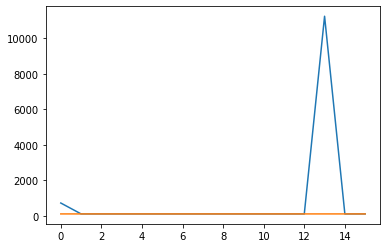

NB OF OBSERVATIONS TO TRAIN: 60
LEARNING RATE: 0.001
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 60 20 
X_train.shape (200, 60, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 60 20 
X_val.shape (40, 60, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 60 20 
X_test.shape (20, 60, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 60, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 60, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 60, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (60, 21)
Model: "sequential_70"
_______________________________________________________________

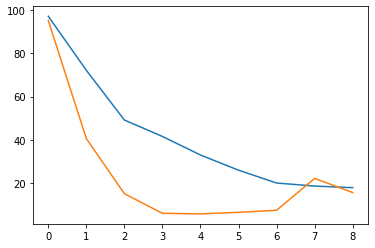

NB OF OBSERVATIONS TO TRAIN: 58
LEARNING RATE: 0.1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 58 20 
X_train.shape (200, 58, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 58 20 
X_val.shape (40, 58, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 58 20 
X_test.shape (20, 58, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 58, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 58, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 58, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (58, 21)
Model: "sequential_71"
_________________________________________________________________

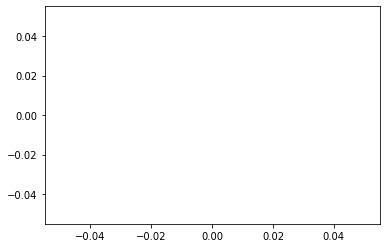

NB OF OBSERVATIONS TO TRAIN: 58
LEARNING RATE: 0.01
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 58 20 
X_train.shape (200, 58, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 58 20 
X_val.shape (40, 58, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 58 20 
X_test.shape (20, 58, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 58, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 58, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 58, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (58, 21)
Model: "sequential_72"
________________________________________________________________

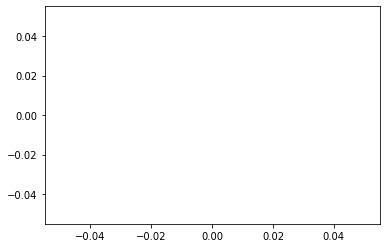

NB OF OBSERVATIONS TO TRAIN: 58
LEARNING RATE: 0.001
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 58 20 
X_train.shape (200, 58, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 58 20 
X_val.shape (40, 58, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 58 20 
X_test.shape (20, 58, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 58, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 58, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 58, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (58, 21)
Model: "sequential_73"
_______________________________________________________________

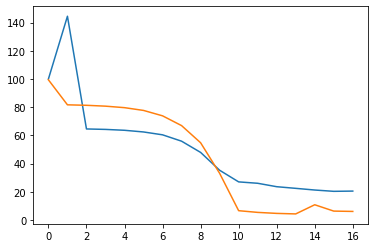

In [56]:
model_run(country_name='France', n_seq=200, n_obs=[62, 60, 58], n_feat=20, n_pred=1, split_train=0.7, split_val=0.9, learning_rates=[0.1, 0.01, 0.001])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 [62, 60, 58] 
n_feat		 20
NB OF OBSERVATIONS TO TRAIN: 62
LEARNING RATE: 0.1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 62 20 
X_train.shape (200, 62, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 62 20 
X_val.shape (40, 62, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 62 20 
X_test.shape (20, 62, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 62, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 62, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 62, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 62, 21)
Model

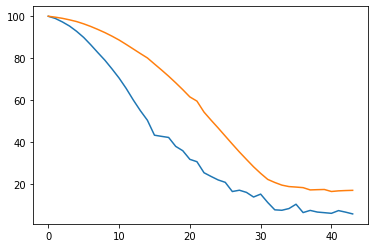

NB OF OBSERVATIONS TO TRAIN: 62
LEARNING RATE: 0.01
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 62 20 
X_train.shape (200, 62, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 62 20 
X_val.shape (40, 62, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 62 20 
X_test.shape (20, 62, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 62, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 62, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 62, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 62, 21)
Model: "sequential_122"
__________________________________________________________

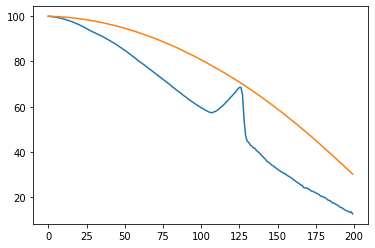

NB OF OBSERVATIONS TO TRAIN: 62
LEARNING RATE: 0.001
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 62 20 
X_train.shape (200, 62, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 62 20 
X_val.shape (40, 62, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 62 20 
X_test.shape (20, 62, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 62, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 62, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 62, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 62, 21)
Model: "sequential_123"
_________________________________________________________

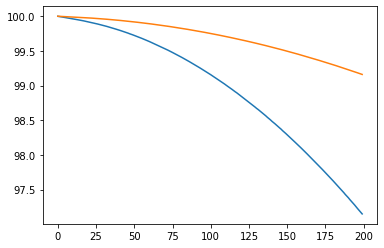

NB OF OBSERVATIONS TO TRAIN: 60
LEARNING RATE: 0.1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 60 20 
X_train.shape (200, 60, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 60 20 
X_val.shape (40, 60, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 60 20 
X_test.shape (20, 60, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 60, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 60, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 60, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 60, 21)
Model: "sequential_124"
___________________________________________________________

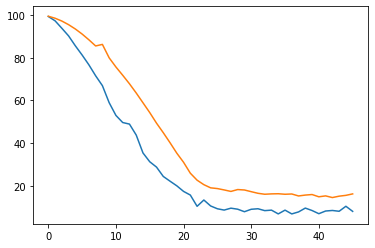

NB OF OBSERVATIONS TO TRAIN: 60
LEARNING RATE: 0.01
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 60 20 
X_train.shape (200, 60, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 60 20 
X_val.shape (40, 60, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 60 20 
X_test.shape (20, 60, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 60, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 60, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 60, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 60, 21)
Model: "sequential_125"
__________________________________________________________

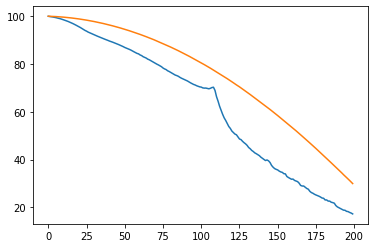

NB OF OBSERVATIONS TO TRAIN: 60
LEARNING RATE: 0.001
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 60 20 
X_train.shape (200, 60, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 60 20 
X_val.shape (40, 60, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 60 20 
X_test.shape (20, 60, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 60, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 60, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 60, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 60, 21)
Model: "sequential_126"
_________________________________________________________

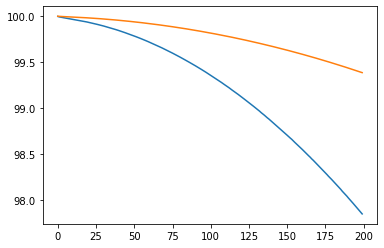

NB OF OBSERVATIONS TO TRAIN: 58
LEARNING RATE: 0.1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 58 20 
X_train.shape (200, 58, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 58 20 
X_val.shape (40, 58, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 58 20 
X_test.shape (20, 58, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 58, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 58, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 58, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 58, 21)
Model: "sequential_127"
___________________________________________________________

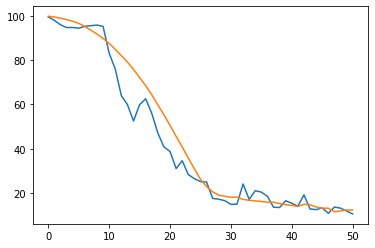

NB OF OBSERVATIONS TO TRAIN: 58
LEARNING RATE: 0.01
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 58 20 
X_train.shape (200, 58, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 58 20 
X_val.shape (40, 58, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 58 20 
X_test.shape (20, 58, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 58, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 58, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 58, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 58, 21)
Model: "sequential_128"
__________________________________________________________

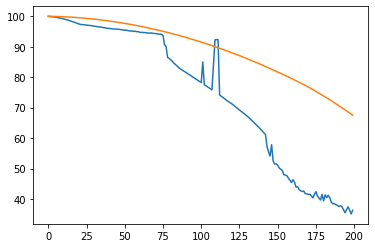

NB OF OBSERVATIONS TO TRAIN: 58
LEARNING RATE: 0.001
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
n_seq / n_obs / n_feat 200 58 20 
X_train.shape (200, 58, 21) y_train.shape (200, 1)
n_seq_val / n_obs / n_feat 40 58 20 
X_val.shape (40, 58, 21) y_val.shape (40, 1)
n_seq_test / n_obs / n_feat 20 58 20 
X_test.shape (20, 58, 21) y_test.shape (20, 1)
Check data before training
X_train.shape	 (200, 58, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 58, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 58, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>
n_pred 1
input_shape (200, 58, 21)
Model: "sequential_129"
_________________________________________________________

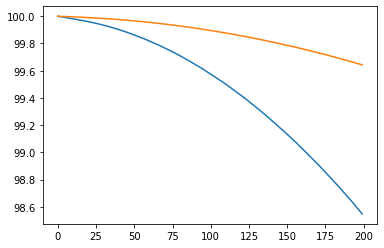

In [78]:
model_run(country_name='France', n_seq=200, n_obs=[62, 60, 58], n_feat=20, n_pred=1, split_train=0.7, split_val=0.9, learning_rates=[0.1, 0.01, 0.001])

Epoch 1/200
12/12 [==============================] - 0s 11ms/step - loss: 69975640.0000 - mape: 153323159552.0000 - val_loss: 82468712.0000 - val_mape: 116827553792.0000
Epoch 2/200
12/12 [==============================] - 0s 10ms/step - loss: 65886224.0000 - mape: 207705014272.0000 - val_loss: 82640696.0000 - val_mape: 101916803072.0000
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 61841324.0000 - mape: 291052716032.0000 - val_loss: 72093224.0000 - val_mape: 337681678336.0000
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 7205288448.0000 - mape: 4425933914112.0000 - val_loss: 67540992.0000 - val_mape: 65798184960.0000
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 60565528.0000 - mape: 117270069248.0000 - val_loss: 69876304.0000 - val_mape: 54863540224.0000
Epoch 6/200
12/12 [==============================] - 0s 13ms/step - loss: 192822880.0000 - mape: 1091883958272.0000 - val_loss: 1341478016.0000 - val

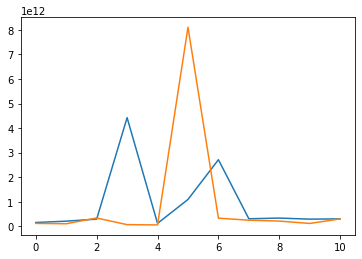

In [72]:
# 3. Training
history = train_rnn_model(model=rnn_model_4, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=200, patience=3)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();

# 4. Evaluating
# The prediction (one per sequence/city)
# y_pred = rnn_model.predict(X_test) 
# print(y_pred.shape)
# Distribution of the predictions
# pd.DataFrame(y_pred).mean().sort_values(ascending=False)

## RNN model #4 end of the road...

In [ ]:
# 0. The Normalization Layer
normalizer = Normalization()  # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

### RNN model #3 architecture 

In [ ]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Model #1 evaluating

In [ ]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

### Time Series Forecasting with model #1

### Compile model #3 with 'rmsprop'

In [ ]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

In [ ]:
rnn_model.summary()

### Train model #2

In [ ]:
history = train_rnn_model(rnn_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

In [ ]:
trai### Train model #1n_series = [50, 150, 200, 300, 400]
overfit_es =   [2, 6, 6, 5, 6 ]
print('type(overfit_es), overfit_es', type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
for i in range(len(train_series)):
    history = train_rnn_model(model=rnn_model_2, epochs=train_series[i], patience=overfit_es[i])
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.show();

### RNN model #3 architecture 

#### 🚀 The **LSTM (= Long Short Term Memory)** with their ability to *avoid the vanishing gradient problem*, should be preferred over a SimpleRNN.

In [ ]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Compile model #3 with 'rmsprop'

In [ ]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

### Train model #2

### RNN model #3 architecture 

In [ ]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Compile model #3 with 'rmsprop'

In [ ]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

### Train model #3

### Train model #2

In [ ]:
# min(history.history['mape'])

# print("adjust early stopping")
# overfit_es = [d[0]+1 for d in enumerate(history.history['mape']) if d[1] == min(history.history['mape'])][0]
# overfit_es

In [ ]:
min(history.history['mape']), max(history.history['mape']), history.history['mape'] # blue line

In [ ]:
max(history.history['val_mape']), history.history['val_mape'] # orange line

### Model #1 evaluating

In [ ]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

### Time Series Forecasting with model #1

In [ ]:
# Check your code below
assert y_pred.shape == (n_seq_test, n_pred)
# Distribution of the real values y_train
pd.DataFrame(y_train).mean().sort_values(ascending=False)

In [ ]:
# Distribution of the real values y_train
pd.DataFrame(y_train).mean().sort_values(ascending=False)

In [ ]:
trai### Train model #1n_series = [50, 150, 200, 300, 400]
overfit_es =   [2, 6, 6, 5, 6 ]
print('type(overfit_es), overfit_es', type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
for i in range(len(train_series)):
    history = train_rnn_model(model=rnn_model_2, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=train_series[i], patience=overfit_es[i])
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.show();